First, import data to compare (neuron 20 vs 45 for 'RoyMaze1' session from Hiro dataset).

In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == 'Linux': # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
elif platform.system() == 'Darwin':
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
elif platform.system() == 'Windows':
    pass

import neuropy.analyses.correlations as ccg
from neuropy.core.neurons import Neurons

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
from scipy.io import loadmat

filepath = '/data/Working/Other_Peoples_Data/HiroData/wake_new/wake-spikes.mat'
session = 'RoyMaze1'

mat_in = loadmat(filepath, squeeze_me=True, struct_as_record=False)

Organize data

In [3]:
# Import specific neuron spiketrains from .mat file
neurons = [19, 44]
spikes_use = [mat_in['spikes'].RoyMaze1[neuron] for neuron in neurons]

In [4]:
# Convert to NeuroPy format
time_to_sec = 1/(1000*1000)  # Hiro data times are in microseconds
spiketrains = [a.time * time_to_sec for a in spikes_use]

neurons_use = Neurons(spiketrains=spiketrains, t_start=68368, t_stop=103720)

Now, run ccg and plot it!

0.007


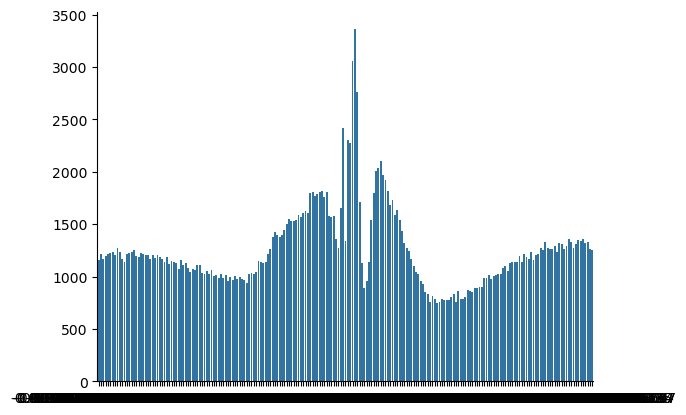

In [5]:
# run ccg
window_size, bin_size = 0.007, 1/30000
ccg_use = ccg.spike_correlations(neurons_use, [0, 1], window_size=window_size, bin_size=bin_size, sample_rate=30000, use_cupy=False)

# plot ccg
bins = np.linspace(-window_size/2, window_size/2, num=int(window_size/bin_size + 1))
sns.barplot(x=bins, y=ccg_use[1,0,:])
sns.despine()

### Note- CuPy functionality is broken and will need debugging to get working

In [ ]:
# run ccg
window_size, bin_size = 0.007, 1/30000
ccg_use = ccg.spike_correlations(neurons_use, [0, 1], window_size=window_size, bin_size=bin_size, sample_rate=30000, use_cupy=True)

# plot ccg
bins = np.linspace(-window_size/2, window_size/2, num=int(window_size/bin_size + 1))
sns.barplot(x=bins, y=ccg_use[1,0,:])
sns.despine()